# Demo for ranking protein-protein interface using Graph Convolution

## Project setup

In [ ]:
# Copying data and code from GitHub repository
!git clone https://github.com/withai/Demo-Ranking-protein-protein-interfaces-using-GNN.git
!mv Demo-Ranking-protein-protein-interfaces-using-GNN/* .
!rm -r Demo-Ranking-protein-protein-interfaces-using-GNN

## Import libraries

In [1]:
# Import PyTorch
import torch
import torch.backends.cudnn as cudnn
from torch.utils import data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.init as init

# Import Neural Network layer
from nn import Dense

# Import utility functions
from dataset import Dataset
from sampler import CustomSampler
from train import train
from test import test

# Import libraries for graphing
import pandas as pd
import numpy as np
from graph import show_results
import matplotlib.pyplot as plt
%matplotlib inline



## Run computation on GPU or CPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Define Graph Convolution layer

$$
h^{(l)}_i = \sigma \left(\mathbf{W}^{(l)}_c h^{(l-1)}_i +
    \frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} \right.  \left. + \frac{1}{|N_i^{(prot)}|}\sum_{j \epsilon N_i^{(prot)}} \mathbf{W}^{(l)}_{prot} h^{(l-1)}_j \bigodot E_{ij} + b^{(l)} \vphantom{\frac{1}{|N_i^{(neigh)}|}}\right)
$$


where for the layer $l$,  

$\mathbf{W}^{(l)}_c$ is the weight matrix for learning representations w.r.t central node,

$\mathbf{W}^{(l)}_{int}$ and $\mathbf{W}^{(l)}_{prot}$ are the weight matrix for learning representations w.r.t the neighbor nodes in the interface graph and the protein graph respectively,

$b^{(l)}$ is the bias vector, 

$h^{(l)}_i$ is the hidden node embedding of node $i$,

$N_i^{(int)}$ is the number of atoms surrounding node $i$ in the interface graph, 

$N_i^{(prot)}$ is the number of atoms surrounding node $i$ in the protein graph, 

$\sigma$  is the activation function, and

$E_{ij}$ is the value in the edge matrix between node $i$ and node $j$.

### How does computing neighborhood signals look like in the code?

Let's compute neighborhood signals in the interface graph

$
\begin{align}
\frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} 
\end{align}
$

**Define all the variables**

In [3]:
# node features: One-hot encoding of 11 different atom types
node_feat = torch.tensor([
                            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # atom 1
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # atom 2
                            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], # atom 3
                            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # atom 4 
                        ]).type(torch.float)

# indices of neighbor atoms in interface graph
int_indices = torch.tensor([
                            [1, 2, -1],  # neighbors of atom 1
                            [0, -1, -1], # neighbors of atom 2
                            [1, -1, -1], # neighbors of atom 3
                            [-1, -1, -1] # neighbors of atom 4
                          ])

# edge weights of neighbor atoms in interface graph
int_edges = torch.tensor([
                            [0.9, 0.2, -1], # weights of neighbors of atom 1
                            [0.1, -1, -1],  # weights of neighbors of atom 2
                            [0.5, -1, -1],  # weights of neighbors of atom 3
                            [-1, -1, -1]    # weights of neighbors of atom 4
                        ])

# weight matrix
num_of_features = 11
filters = 16

w_int = torch.randn(num_of_features, filters)


**Step 1: Compute signals for all the nodes in the graph**

In [4]:
node_Wn_int = torch.matmul(node_feat, w_int)

print(node_Wn_int.shape)
print(node_Wn_int)

torch.Size([4, 16])
tensor([[ 1.9271,  1.4316, -1.0644,  0.7279, -0.2573,  0.8141,  0.7992,  0.5950,
         -0.0411,  1.1367, -0.8156,  1.3591, -0.0407, -0.3058,  0.1911, -0.1502],
        [ 0.4444,  0.5052,  1.2067,  1.9365,  0.3248,  1.7097,  0.8108, -1.9328,
         -0.1179, -1.0398, -0.2712,  0.4724,  2.2838,  0.6347, -1.4750, -0.9735],
        [-0.4510, -0.1511, -1.5775,  0.7738,  1.8250,  0.7037, -2.6085,  0.6280,
          2.0199, -0.5045,  1.0678,  0.5699,  0.8970, -0.3461,  2.0094, -0.9390],
        [ 0.9336, -0.5197,  0.6133,  1.4239, -0.2088,  0.6388,  0.0661, -0.2356,
          0.0316, -0.1286, -0.5737,  0.6740,  1.3765,  0.5369, -0.5896, -1.7138]])


**Step 2: Find all the neighbors of atoms that are participating in the interface graph**

In [5]:
int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)

print(int_part.shape)
print(int_part)

torch.Size([4, 3, 1])
tensor([[[1.],
         [1.],
         [0.]],

        [[1.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]])


**Step 3: For each atom find the number of neighbors participating in the graph**

In [6]:
no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1)

print(no_of_neighs_int.shape)
print(no_of_neighs_int)

torch.Size([4, 1])
tensor([[2],
        [1],
        [1],
        [0]])


**Step 4a: Make sure we don't divide by zeros**

In [7]:
no_of_neighs_int[no_of_neighs_int == 0] = 1

print(no_of_neighs_int.shape)
print(no_of_neighs_int)

torch.Size([4, 1])
tensor([[2],
        [1],
        [1],
        [1]])


**Step 4b: Expand the dimension of edge weights to allow scalar multiplication**

In [8]:
int_edges = torch.unsqueeze(int_edges, 2)

print(int_edges.shape)
print(int_edges)

torch.Size([4, 3, 1])
tensor([[[ 0.9000],
         [ 0.2000],
         [-1.0000]],

        [[ 0.1000],
         [-1.0000],
         [-1.0000]],

        [[ 0.5000],
         [-1.0000],
         [-1.0000]],

        [[-1.0000],
         [-1.0000],
         [-1.0000]]])


**Step 5: Compute neighbor signals of all the nodes in the interface graph**

Step 5a: Grab all the neighbors of interface atoms

In [9]:
Zn_inter_intermediate_result = node_Wn_int[int_indices]

print(node_Wn_int[int_indices].shape)
print(node_Wn_int[int_indices])

torch.Size([4, 3, 16])
tensor([[[ 0.4444,  0.5052,  1.2067,  1.9365,  0.3248,  1.7097,  0.8108,
          -1.9328, -0.1179, -1.0398, -0.2712,  0.4724,  2.2838,  0.6347,
          -1.4750, -0.9735],
         [-0.4510, -0.1511, -1.5775,  0.7738,  1.8250,  0.7037, -2.6085,
           0.6280,  2.0199, -0.5045,  1.0678,  0.5699,  0.8970, -0.3461,
           2.0094, -0.9390],
         [ 0.9336, -0.5197,  0.6133,  1.4239, -0.2088,  0.6388,  0.0661,
          -0.2356,  0.0316, -0.1286, -0.5737,  0.6740,  1.3765,  0.5369,
          -0.5896, -1.7138]],

        [[ 1.9271,  1.4316, -1.0644,  0.7279, -0.2573,  0.8141,  0.7992,
           0.5950, -0.0411,  1.1367, -0.8156,  1.3591, -0.0407, -0.3058,
           0.1911, -0.1502],
         [ 0.9336, -0.5197,  0.6133,  1.4239, -0.2088,  0.6388,  0.0661,
          -0.2356,  0.0316, -0.1286, -0.5737,  0.6740,  1.3765,  0.5369,
          -0.5896, -1.7138],
         [ 0.9336, -0.5197,  0.6133,  1.4239, -0.2088,  0.6388,  0.0661,
          -0.2356,  0.0316,

Step 5b: Select all the participating neighbors

In [10]:
Zn_inter_intermediate_result = node_Wn_int[int_indices] * int_part

print(Zn_inter_intermediate_result.shape)
print(Zn_inter_intermediate_result)

torch.Size([4, 3, 16])
tensor([[[ 0.4444,  0.5052,  1.2067,  1.9365,  0.3248,  1.7097,  0.8108,
          -1.9328, -0.1179, -1.0398, -0.2712,  0.4724,  2.2838,  0.6347,
          -1.4750, -0.9735],
         [-0.4510, -0.1511, -1.5775,  0.7738,  1.8250,  0.7037, -2.6085,
           0.6280,  2.0199, -0.5045,  1.0678,  0.5699,  0.8970, -0.3461,
           2.0094, -0.9390],
         [ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000, -0.0000]],

        [[ 1.9271,  1.4316, -1.0644,  0.7279, -0.2573,  0.8141,  0.7992,
           0.5950, -0.0411,  1.1367, -0.8156,  1.3591, -0.0407, -0.3058,
           0.1911, -0.1502],
         [ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000, -0.0000],
         [ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          -0.0000,  0.0000,

Step 5c: Scale each of the participating neighbor by its edge weight

$\mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij}$

In [11]:
Zn_inter_intermediate_result = node_Wn_int[int_indices] * int_part * int_edges

print(Zn_inter_intermediate_result.shape)
print(Zn_inter_intermediate_result)

torch.Size([4, 3, 16])
tensor([[[ 0.4000,  0.4547,  1.0861,  1.7428,  0.2923,  1.5387,  0.7297,
          -1.7395, -0.1061, -0.9358, -0.2441,  0.4251,  2.0554,  0.5712,
          -1.3275, -0.8762],
         [-0.0902, -0.0302, -0.3155,  0.1548,  0.3650,  0.1407, -0.5217,
           0.1256,  0.4040, -0.1009,  0.2136,  0.1140,  0.1794, -0.0692,
           0.4019, -0.1878],
         [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
           0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
           0.0000,  0.0000]],

        [[ 0.1927,  0.1432, -0.1064,  0.0728, -0.0257,  0.0814,  0.0799,
           0.0595, -0.0041,  0.1137, -0.0816,  0.1359, -0.0041, -0.0306,
           0.0191, -0.0150],
         [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
           0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
           0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
           0.0000, -0.0000,

Step 5d: Sum all the neighbors of an atom

$\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij}$

In [12]:
Zn_inter_intermediate_result = torch.sum(node_Wn_int[int_indices] * int_part * int_edges, 1)

print(Zn_inter_intermediate_result.shape)
print(Zn_inter_intermediate_result)

torch.Size([4, 16])
tensor([[ 0.3098,  0.4244,  0.7706,  1.8976,  0.6573,  1.6794,  0.2080, -1.6139,
          0.2978, -1.0368, -0.0306,  0.5391,  2.2348,  0.5020, -0.9257, -1.0640],
        [ 0.1927,  0.1432, -0.1064,  0.0728, -0.0257,  0.0814,  0.0799,  0.0595,
         -0.0041,  0.1137, -0.0816,  0.1359, -0.0041, -0.0306,  0.0191, -0.0150],
        [ 0.2222,  0.2526,  0.6034,  0.9682,  0.1624,  0.8548,  0.4054, -0.9664,
         -0.0590, -0.5199, -0.1356,  0.2362,  1.1419,  0.3173, -0.7375, -0.4868],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


Step 5e: Divide with the number of atoms in interface graph

$\frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} $

In [13]:
Zn_inter = torch.sum(node_Wn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int

print(Zn_inter.shape)
print(Zn_inter)

torch.Size([4, 16])
tensor([[ 0.1549,  0.2122,  0.3853,  0.9488,  0.3287,  0.8397,  0.1040, -0.8069,
          0.1489, -0.5184, -0.0153,  0.2696,  1.1174,  0.2510, -0.4628, -0.5320],
        [ 0.1927,  0.1432, -0.1064,  0.0728, -0.0257,  0.0814,  0.0799,  0.0595,
         -0.0041,  0.1137, -0.0816,  0.1359, -0.0041, -0.0306,  0.0191, -0.0150],
        [ 0.2222,  0.2526,  0.6034,  0.9682,  0.1624,  0.8548,  0.4054, -0.9664,
         -0.0590, -0.5199, -0.1356,  0.2362,  1.1419,  0.3173, -0.7375, -0.4868],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


### GCN Layer code

In [14]:
class GCN_layer(nn.Module):

    def __init__(self, v_feats, filters, dropout=0.1, bias=True, trainable=True, **kwargs):

        super(GCN_layer, self).__init__()

        self.v_feats = v_feats
        self.filters = filters
        self.dropout= dropout
        self.bias = bias
        self.trainable = trainable
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        
        # Define non-linear function
        self.non_lin = nn.LeakyReLU()

        # Initialize dropout
        self.drop_layer = nn.Dropout(p=self.dropout)
       
        # Initialize learnable parameters
        self.Wvc = nn.Parameter(
                    init.kaiming_uniform_(
                        torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                            .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_int = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_prot = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.bv = nn.Parameter(
                        torch.zeros(self.filters, requires_grad=self.trainable)
                            .type(torch.float).to(self.device))
        
        
    def forward(self, x):

        node_feat, prot_indices, int_indices, prot_edges, int_edges = x

        # generate center node signals
        Zc = torch.matmul(node_feat, self.Wvc)  # (n_verts, filters)

        # create neighbor signals
        v_Wvn_int = torch.matmul(node_feat, self.Wvn_int)  # (n_verts, filters)
        v_Wvn_prot = torch.matmul(node_feat, self.Wvn_prot)  # (n_verts, filters)
        
        # Find participating neighbors of the interface and protein graph in Graph Convolution 
        int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)
        prot_part = torch.unsqueeze(prot_indices > -1, 2).type(torch.float)

        # Find the number of neighbors per atom
        no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_prot = torch.sum(prot_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_int[no_of_neighs_int == 0] = 1
        no_of_neighs_prot[no_of_neighs_prot == 0] = 1
        
        # Expand interface and neighborh edge matrices to allow scalar multiplication
        if(len(int_edges.size()) != 3):
            int_edges = torch.unsqueeze(int_edges, 2)
            prot_edges = torch.unsqueeze(prot_edges, 2)

        # Generate neighbor signals w.r.t the interface and protein graph
        Zn_inter = torch.sum(v_Wvn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int
        Zn_prot = torch.sum(v_Wvn_prot[prot_indices] * prot_part * prot_edges, 1) / no_of_neighs_prot

        # Combine central and neighbor signals
        Z = Zc + Zn_inter + Zn_prot

        # Add bias
        if self.bias:
            Z += self.bv

        # Apply activation function
        h = self.non_lin(Z)

        # Apply dropout
        if self.dropout:
            h = self.drop_layer(h)


        return [h, prot_indices, int_indices, prot_edges, int_edges]

## Define Graph Neural network

In [15]:
class GNN(torch.nn.Module):
    """
        GCN + Normalize pool + L1-loss
    """
    def __init__(self):
        super(GNN, self).__init__()

        # Define neural network layers
        self.conv1 = GCN_layer(v_feats=11, filters=16, dropout=0.1)
        self.conv2 = GCN_layer(v_feats=16, filters=32, dropout=0.1)
        self.conv3 = GCN_layer(v_feats=32, filters=64, dropout=0.1)
        self.dense = Dense(in_dims=64, out_dims=1, nonlin="linear")

        # Define optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0.0001)

    def forward(self, x):
        
        # GCN layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x[0]
        # each row of x is now a feature vector.

        # Graph pooling
        x = torch.sum(x, 0).view(1, -1)
        x = F.normalize(x)

        # Dense layer
        x = self.dense(x)
        x = torch.squeeze(x, 1)

        return x

    def loss(self, output, target, reduction='mean'):
        # Define loss function
        return F.l1_loss(output, target, reduction=reduction)

## Initialize Graph Neural Network

In [16]:
model = GNN().to(device)

## Initialize PyTorch data loader and data sampler

In [17]:
dataset_path = "data"

# Train dataset generator 
train_dataset = Dataset(dataset_path, "train")
train_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 50,
                                   dataset_path = dataset_path,
                                   dataset_cat = "train",
                                   random_sample = True),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
training_generator = data.DataLoader(train_dataset, **train_params)

# Test dataset generator
test_dataset = Dataset(dataset_path, "test")
test_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 50,
                                   dataset_path = dataset_path,
                                   dataset_cat = "test"),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
test_generator = data.DataLoader(test_dataset, **test_params)

No. of train complexes: 3
No. of test complexes: 2


## Train model

In [18]:
epochs = 10
mini_batches_per_epoch = 30

loss = []

for epoch in range(0, epochs):
    
    loss_ = train(model, device, training_generator, model.optimizer, epoch, mini_batches_per_epoch)
    
    loss.append(loss_)
    
    print("Epoch " + str(epoch+1)+ " loss : " + str(loss_))
    

Epoch 1 loss : 1.4782438278198242
Epoch 2 loss : 1.2398577630519867
Epoch 3 loss : 0.4327930845320225
Epoch 4 loss : 0.9369983077049255
Epoch 5 loss : 0.42369863390922546
Epoch 6 loss : 0.32311929762363434
Epoch 7 loss : 0.524371325969696
Epoch 8 loss : 0.39155422151088715
Epoch 9 loss : 0.10645942855626345
Epoch 10 loss : 0.27297094464302063


## Plot loss function

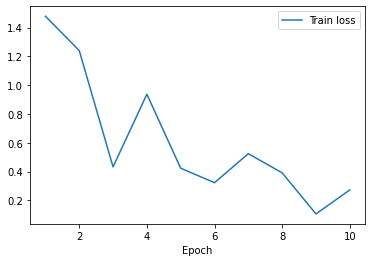

In [19]:
epoch_list = list(range(1, epochs+1))
epoch_losses = list(zip(epoch_list, loss))

loss_df = pd.DataFrame(epoch_losses, columns=["Epoch", "Train loss"])

lines = loss_df.plot.line(x="Epoch", y="Train loss")


## Test model

In [20]:
dockq_threshold = 0.65
top_ns = [1, 5, 10, 20, 50]

top_n_results, scores_dockq = test(model, device, test_generator, dockq_threshold, top_ns)

print("Number of complexes in the test set for which the decoys above a DockQ value of " + str(dockq_threshold) + 
      " are ranked in the top-n")
print("Total number of complexes in test set: " + str(len(test_dataset)) + "\n")
for i in range(len(top_ns)):
    print("Top " + str(top_ns[i]) + " : " + str(top_n_results[i]) + " complexes")
    

Number of complexes in the test set for which the decoys above a DockQ value of 0.65 are ranked in the top-n
Total number of complexes in test set: 2

Top 1 : 0 complexes
Top 5 : 0 complexes
Top 10 : 0 complexes
Top 20 : 0 complexes
Top 50 : 0 complexes


### Test complex 1 results

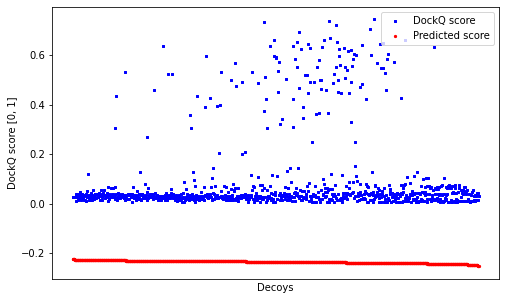

In [21]:
show_results("1b6c", scores_dockq)

### Test complex 2 results

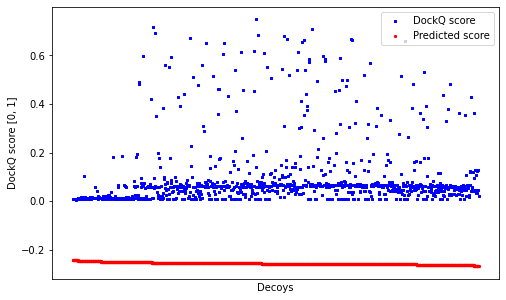

In [22]:
show_results("1e6e", scores_dockq)